In [27]:
from pandas import read_csv, DataFrame
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, rdFingerprintGenerator
from rdkit.Chem import Draw
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from numpy import sqrt, array
import shap
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdCoordGen import AddCoords as addcord
from warnings import filterwarnings
from random import seed
import optuna
import pickle

filterwarnings("ignore")

In [28]:
seed(0)
data = read_csv('../../../DATABASE/no_missing_data.csv')
data

,molecule,smiles,max_abs,max_em,solvent,dc,etn
0,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,620.0,DMSO,46.8260,0.444
1,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,565.0,H2O,78.3553,1.000
2,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,575.0,AcOEt,6.0200,0.228
3,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,450.0,615.0,DCM,8.9300,0.309
4,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,615.0,ACN,35.6880,0.460
...,...,...,...,...,...,...,...
696,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,380.0,536.0,DCM,8.9300,0.309
697,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,374.0,549.0,ACN,37.5000,0.460
698,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,376.0,570.0,DIOX,2.2500,0.164
699,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,377.0,560.0,DCM,8.9300,0.309


In [ ]:
# seed(0)

# NamesMol = data['molecule']
# SolventMol = data['solvent']

In [ ]:
def prepare_data(data):
    PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
    radius = 4
    fp_size = 2048
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fp_size)
    morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]
    morgan_df = DataFrame(morgan_fps)
    morgan_df.columns = ['MF_' + str(j + 1) for j in morgan_df.columns]
    
    morgan_df['etn'] = data['etn'].to_numpy()

    X_fps = morgan_df.to_numpy()
    y_fps = data['max_em'].to_numpy()
    
    return X_fps, y_fps

def evaluate_random_state(random_state, X, y):
    model_fps = RandomForestRegressor(random_state=58, n_jobs=-1)
    cv_fps = KFold(n_splits=10, shuffle=True, random_state=random_state)
    scores_fps = cross_val_score(model_fps, X, y, scoring='r2', cv=cv_fps, n_jobs=-1).mean()
    return scores_fps, random_state

def find_best_random_state(data, n_states=100):
    X_fps, y_fps = prepare_data(data)
    
    best_score = float('-inf')
    best_random_state = None
    
    print("Random State | Mean R2 Score")
    print("-" * 30)
    
    for random_state in range(n_states):
        score, _ = evaluate_random_state(random_state, X_fps, y_fps)
        print(f"{random_state:12d} | {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_random_state = random_state
    
    print("-" * 30)
    print(f"Best random state: {best_random_state}")
    print(f"Best mean R2 score: {best_score:.4f}")
    
    return best_random_state, best_score

# Usage
np.random.seed(0)
best_random_state, best_score = find_best_random_state(data)

best random_state RandomForest for abs KFold: 31

best random_state RandomForest for em KFold: 63

In [29]:
seed(0)

np.random.seed(0)


PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
        # Create the fingerprint generator
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 4, fpSize = 2048)

# Generate fingerprints for each molecule
morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]

morgan_df = DataFrame(morgan_fps)

morgan_df.columns = ['MF_' + str(j+1) for j in morgan_df.columns]
morgan_df['etn'] = data['etn'].to_numpy()
# morgan['dc'] = data['dc'].values
# morgan_df['molecule'] = data['molecule'].values
# morgan_df.to_csv('morgan.csv', index=False)

In [ ]:
seed(0)
np.random.seed(0)
test = {}

def objective(trial):

    params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 300),
    # "max_depth": trial.suggest_int("max_depth", None, 8),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    # "max_samples": trial.suggest_float("max_samples", None, 1.0) if trial.suggest_categorical("bootstrap", [True, False]) == True else None
}

    model = RandomForestRegressor(**params, random_state=58)
    cv = KFold(n_splits=10, shuffle=True, random_state=63)

    x_kf = morgan_df.to_numpy()
    y_kf = data['max_abs'].to_numpy()

    mse_scores = cross_val_score(model, x_kf, y_kf, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    r2_scores = cross_val_score(model, x_kf, y_kf, scoring='r2', cv=cv, n_jobs=-1)
    
    mean_mse = -mse_scores.mean()
    mean_r2 = r2_scores.mean()

    test.update({'trial':trial, 'mse':mean_mse, 'r2':mean_r2})

    return mean_mse, mean_r2


study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(objective, n_trials=100)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
for i in study.best_trials:
    print(i.params)
    print(i.values)

In [92]:
seed(0)
np.random.seed(0)
# param_abs = {'n_estimators': 522, 'max_depth': 8, 'learning_rate': 0.028564819211536967, 'subsample': 0.8383756107911184, 'colsample_bytree': 0.720080324874693, 'gamma': 0.001754742159327034, 'reg_alpha': 7.710396015328691e-05, 'reg_lambda': 0.09953515181829936, 'min_child_weight': 4}
# param_em = {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.03275426841763309, 'subsample': 0.7530528560775489, 'colsample_bytree': 0.7318698494144726, 'gamma': 6.127310380299753e-08, 'reg_alpha': 0.4795336721521944, 'reg_lambda': 0.005848556892914068, 'min_child_weight': 3}

model_pred = RandomForestRegressor(n_jobs=-1)

X = morgan_df.to_numpy()
Y = data['max_em'].to_numpy()

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

kfold = KFold(n_splits=10, random_state=63, shuffle=True)

In [93]:
seed(0)
np.random.seed(0)
for score in scoring:
    if 'neg' in score:     
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        if 'squared' in score:
            scores = [sqrt(-x) for x in scores]
        else:
            scores = [-x for x in scores]
        mean_scores = np.mean(scores)
        std_scores = np.std(scores)
        print('{}: {:.4f}+-{:.4f}'.format(score, mean_scores, std_scores))

    else:
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        print('{}: {:.4f}+-{:.4f}'.format(score, scores.mean(), scores.std()))

r2: 0.8664+-0.0613
neg_mean_squared_error: 25.3686+-9.2835
neg_mean_absolute_error: 16.2715+-2.9999


**For max_abs**

r2: 0.9252+-0.0400

neg_mean_squared_error: 12.0208+-2.8983

neg_mean_absolute_error: 6.8863+-0.8979


**For max_em**

r2: 0.8884+-0.0300

neg_mean_squared_error: 21.6012+-4.0540

neg_mean_absolute_error: 14.9701+-2.2139

In [ ]:
from numpy import sqrt
sqrt(4.0540)

$Erro = \frac{\sqrt{MSE}}{\bar{Y}}*100$

In [ ]:
19.1158**2

In [ ]:
print('Erro % = {:.4f}'.format(((sqrt(365.41380964))/(Y).mean())*100))

In [94]:
seed(0)

model_pred.fit(X, Y)

RandomForestRegressor(n_jobs=-1)

In [95]:
error = []

y_preditos = []

for i in range(len(Y)):
    y_expected = Y[i]
    y_pred = model_pred.predict(array(X[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred-y_expected)/y_expected)*100

    if sapato > 1 and y_expected > 720:
        print(y_expected)


    error.append(sapato)


erros_brutos = [x for x in error if x > 1]
len(erros_brutos)

752.0
750.0
786.0
759.0
755.0
870.0
748.0
825.0
890.0


259

In [ ]:
print('Mean Error: {:.4f}%'.format(np.mean(error)))

In [96]:
seed(0)
np.random.seed(0)
# Calculate residuals
residuals = np.abs(Y - np.array(y_preditos))

# Define a threshold for identifying outliers (e.g., 3 standard deviations from the mean)
threshold = 3 * np.std(residuals)

# Identify outliers
outliers = residuals > threshold

# Remove outliers from the dataset
X_clean = X[~outliers]
Y_clean = Y[~outliers]

# Refit the model using the cleaned dataset
model_clean = RandomForestRegressor(n_jobs=-1, random_state=42)
model_clean.fit(X_clean, Y_clean)

# Evaluate the model
kfold_clean = KFold(n_splits=10, random_state=45, shuffle=True)
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'explained_variance']
for score in scoring:
    if 'neg' in score:     
        scores_clean = cross_val_score(model_clean, X_clean, Y_clean, cv=kfold_clean, scoring=score)
        if 'squared' in score:
            scores_clean = [sqrt(-x) for x in scores_clean]
        else:
            scores_clean = [-x for x in scores_clean]
        mean_scores_clean = np.mean(scores_clean)
        std_scores_clean = np.std(scores_clean)
        print('{}: {:.4f}+-{:.4f}'.format(score, mean_scores_clean, std_scores_clean))
    else:
        scores_clean = cross_val_score(model_clean, X_clean, Y_clean, cv=kfold_clean, scoring=score)
        print('{}: {:.4f}+-{:.4f}'.format(score, scores_clean.mean(), scores_clean.std()))
#save the predicted y
y_preditos_clean = []

r2: 0.8884+-0.0300
neg_mean_squared_error: 21.6012+-4.0540
neg_mean_absolute_error: 14.9701+-2.2139
explained_variance: 0.8923+-0.0280


In [ ]:
pickle.dump(model_pred, open('desgraca.pkl', 'wb'))

In [97]:
error = []

y_preditos = []

for i in range(len(Y_clean)):
    y_expected = Y_clean[i]
    y_pred = model_pred.predict(array(X_clean[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred - y_expected) / y_expected) * 100

    if sapato > 1 and y_expected > 720:
        print(y_expected)

    error.append(sapato)

erros_brutos = [x for x in error if x > 1]
len(erros_brutos)


752.0
750.0
755.0
748.0
825.0


237

Iteration 1
R2 scores for Y-randomization: [-0.22365302 -0.21453547 -0.3558707  -0.21672681 -0.64176256 -0.51956851
 -0.13939515 -0.24106174 -0.1175283  -0.06374272]
Mean R2 score for Y-randomization: -0.2733844978387162
Q2 scores: [-0.19936207 -0.19495088 -0.32109949 -0.2075755  -0.59346847 -0.48039889
 -0.12968316 -0.16208375 -0.11316479 -0.05594653]
Mean Q2 score: -0.24577335306888357


Iteration 2
R2 scores for Y-randomization: [-0.64152054 -0.22298638 -0.38412243 -0.44725031 -0.06801599 -0.2337962
 -0.27433072 -0.57755417 -0.23383211 -0.491171  ]
Mean R2 score for Y-randomization: -0.35745798564210035
Q2 scores: [-0.62018724 -0.14267359 -0.33839926 -0.39340855 -0.05718336 -0.23070626
 -0.27211472 -0.57737271 -0.20055029 -0.46061414]
Mean Q2 score: -0.32932101261392566


Iteration 3
R2 scores for Y-randomization: [-0.24053586 -0.17760345 -0.13957228 -0.28188994 -0.28241034 -0.29288619
 -0.50541804 -0.3227467  -0.1476404  -0.30446193]
Mean R2 score for Y-randomization: -0.2695165148

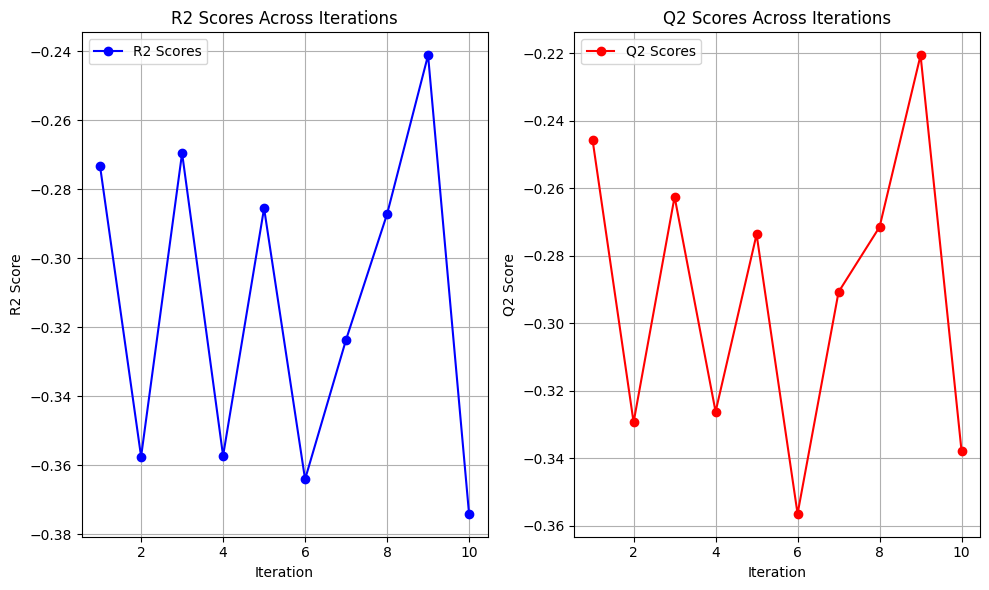

R2 Scores Summary:
Mean: -0.3133012943282171
Standard Deviation: 0.045182220786702004
Min: -0.37402153546755523
Max: -0.24115684302304768

Q2 Scores Summary:
Mean: -0.2914641937170879
Standard Deviation: 0.04203756743060783
Min: -0.35643915761110956
Max: -0.22062280759286007


In [18]:
from sklearn.utils import shuffle

# Initialize lists to store the results
q2_scores = []
r2_scores = []

# Perform 10 iterations
for i in range(10):
    # Shuffle the Y_clean values
    Y_random = shuffle(Y_clean, random_state=i)

    # Initialize the model
    model_random = RandomForestRegressor(n_jobs=-1, random_state=42)

    # Fit the model with the shuffled Y values
    model_random.fit(X_clean, Y_random)

    # Evaluate the model using cross-validation
    r2_scores_random = cross_val_score(model_random, X_clean, Y_random, cv=kfold_clean, scoring='r2')
    q2_scores_random = cross_val_score(model_random, X_clean, Y_random, cv=kfold_clean, scoring='explained_variance')

    # Calculate the mean R2 and Q2 scores
    mean_r2 = np.mean(r2_scores_random)
    mean_q2 = np.mean(q2_scores_random)

    # Store the results
    r2_scores.append(mean_r2)
    q2_scores.append(mean_q2)

    # Print the results for the current iteration
    print(f"Iteration {i+1}")
    print(f"R2 scores for Y-randomization: {r2_scores_random}")
    print(f"Mean R2 score for Y-randomization: {mean_r2}")
    print(f"Q2 scores: {q2_scores_random}")
    print(f"Mean Q2 score: {mean_q2}")
    print("\n")

# Print the overall results
print("Overall R2 scores:", r2_scores)
print("Overall Q2 scores:", q2_scores)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot R2 Scores
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), r2_scores, marker='o', linestyle='-', color='blue', label='R2 Scores')
plt.title('R2 Scores Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('R2 Score')
plt.grid(True)
plt.legend()

# Plot Q2 Scores
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), q2_scores, marker='o', linestyle='-', color='red', label='Q2 Scores')
plt.title('Q2 Scores Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Q2 Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Calculate and print some summary statistics
print("R2 Scores Summary:")
print(f"Mean: {np.mean(r2_scores)}")
print(f"Standard Deviation: {np.std(r2_scores)}")
print(f"Min: {np.min(r2_scores)}")
print(f"Max: {np.max(r2_scores)}")

print("\nQ2 Scores Summary:")
print(f"Mean: {np.mean(q2_scores)}")
print(f"Standard Deviation: {np.std(q2_scores)}")
print(f"Min: {np.min(q2_scores)}")
print(f"Max: {np.max(q2_scores)}")

<Figure size 800x800 with 0 Axes>

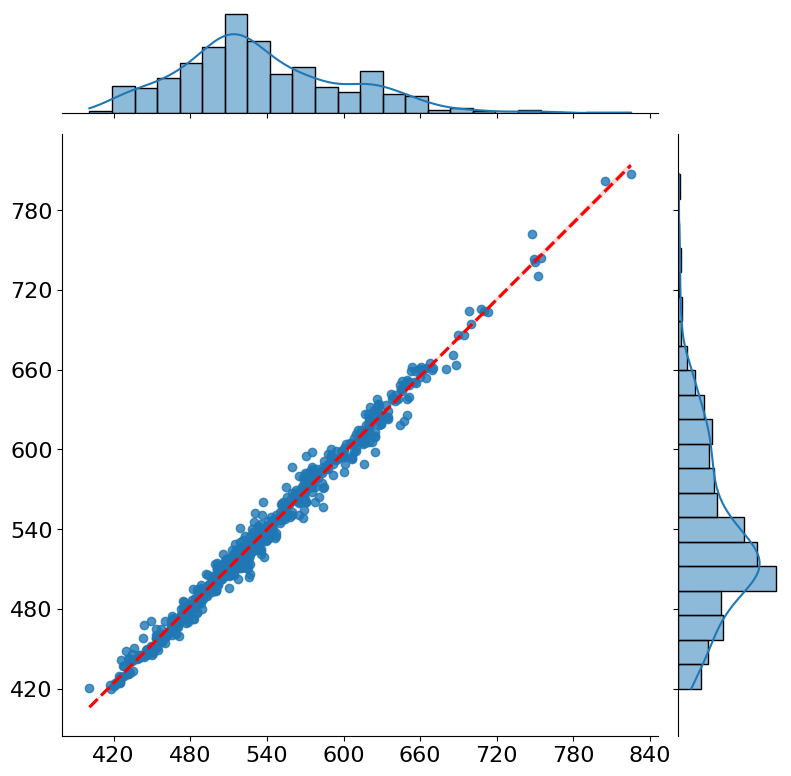

In [98]:
fig = plt.figure(figsize=(8, 8))
# Create a DataFrame for the expected and predicted values
results_df = DataFrame({'Expected': Y_clean, 'Predicted': y_preditos})

# Create the joint plot with a red regression line
joint_plot = sns.jointplot(x='Expected', y='Predicted', data=results_df, kind='reg', height=8, line_kws={'color': 'red', 'linestyle': '--'})

# Set the number of ticks on x and y axes to 8
joint_plot.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=8))
joint_plot.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=8))

# Make the x and y numbers bigger
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=16)

# Remove x and y labels
joint_plot.set_axis_labels('', '')

# Save the image
plt.savefig('RF_scatter_max_.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()